In [1]:
from pyHalo.PresetModels.cdm import CDM
from pyHalo.PresetModels.wdm import WDM
from pyHalo.plotting_routines import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from copy import deepcopy
from pyHalo.truncation_models import truncation_models
from pyHalo.single_realization import Realization

np.random.seed(111)

In [2]:
sigma_sub = 0.4
log_10_half_mode_mass = 7.75

cdm_truncation_roche = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0)

cdm_truncation_galacticus = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos='TRUNCATION_GALACTICUS')
wdm_truncation_galacticus = WDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
                                       log_mc=log_10_half_mode_mass,
                               truncation_model_subhalos='TRUNCATION_GALACTICUS')

kwargs_truncation_model_subhalos_1 = {'median_rt_over_rs': 1.5, 
                                      'c_power': 2.0, 
                                      'intrinsic_scatter': 1.0}
kwargs_truncation_model_subhalos_2 = {'median_rt_over_rs': 1.5, 
                                      'c_power': 4.0, 
                                      'intrinsic_scatter': 1.0}
cdm_truncation_mean_density = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos='TRUNCATION_MEAN_DENSITY', 
                                  kwargs_truncation_model_subhalos=kwargs_truncation_model_subhalos_1)
wdm_truncation_mean_density_1 = WDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
                                       log_mc=log_10_half_mode_mass, 
                               truncation_model_subhalos='TRUNCATION_MEAN_DENSITY',
                                 kwargs_truncation_model_subhalos=kwargs_truncation_model_subhalos_1)
wdm_truncation_mean_density_2 = WDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
                                       log_mc=log_10_half_mode_mass, 
                               truncation_model_subhalos='TRUNCATION_MEAN_DENSITY',
                                 kwargs_truncation_model_subhalos=kwargs_truncation_model_subhalos_2)

lens_cosmo = cdm_truncation_galacticus.lens_cosmo


### TRUNCATION GALACTICUS model

computes distribution of bound mass for subhalos:
$p\left(m_{\rm{bound}}/m_{\rm{infall}}\right)$ as a function of host concentration, subhalos concentration at infall, and the time since infall: $f\left(c_{\rm{host}}, c_{\rm{sub}}, t_{\rm{infall}}\right)$.  

Assume $p\left(m_{\rm{bound}}/m_{\rm{infall}}\right) = \mathcal{N}\left(\mu, \sigma\right)$ where $\mu\left(c_{\rm{host}}, c_{\rm{sub}}, t_{\rm{infall}}\right)$, and $\sigma\left(c_{\rm{host}}, c_{\rm{sub}}, t_{\rm{infall}}\right)$

Given $m_{\rm{bound}}/m_{\rm{infall}}$, calcuate a truncation radius $r_t$ assuming a density profile $\rho\left(r\right) = \rho_{\rm{NFW}}\left(r\right) \frac{r_t^2}{r_s^2 + r_t^2}$

### TRUNCATION MEAN DENSITY model

computes distribution of truncation radii for subhalos:

$p\left(r_t / r_s\right) \sim \mathcal{N}\left(\mu, \sigma\right)$

where the mean is given by

$\mu = \bar{\tau} \ \left(c / \bar{c}\right)^{a} $.

The keyword arguments corresponding to $\tau$ and $a$ are "median_rt_over_rs" and "c_power", respectively. 

The variance is specified in units of r_t / r_s with the keyword argument "intrinsic_scatter". For example, intrinsic_scatter = s sets the variance $s = s \times r_t / r_s$

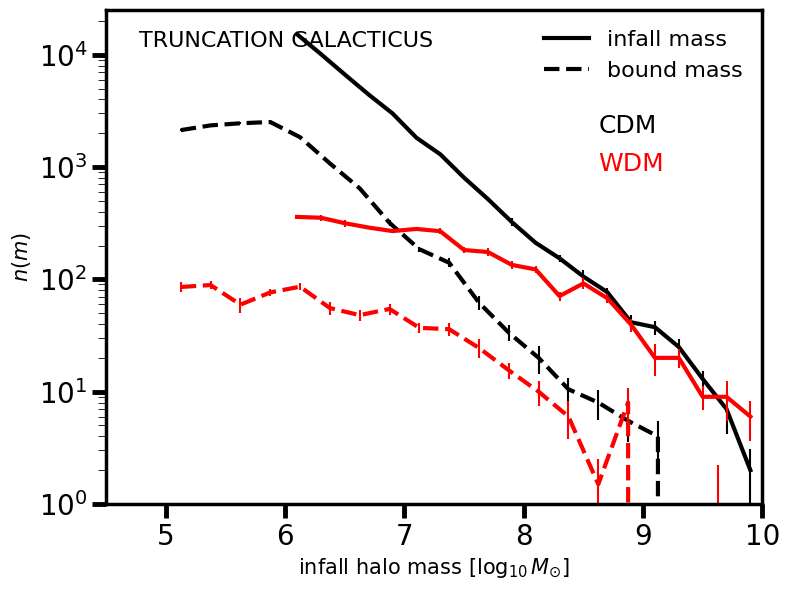

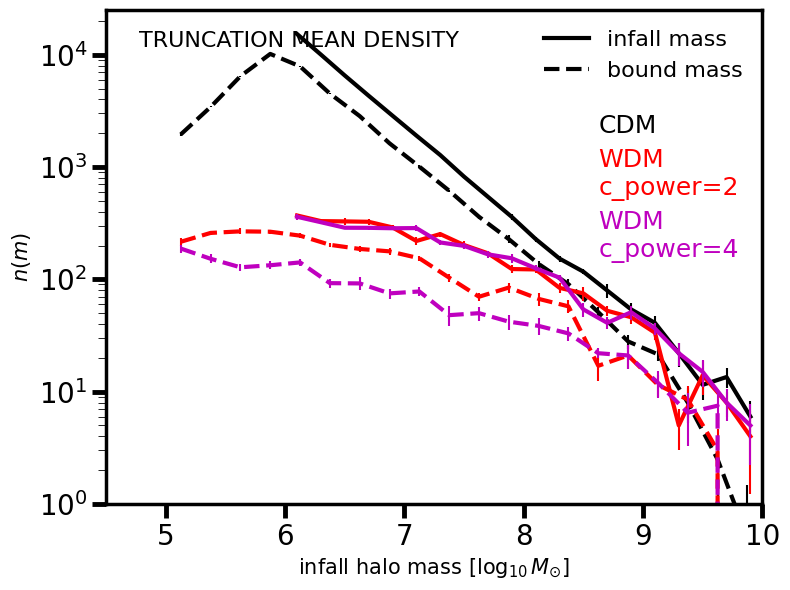

In [3]:
fig = plt.figure(1)
ax = plt.subplot(111)
fig.set_size_inches(8, 6)
kwargs_plot={'lw':3, 'label': 'infall mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'linestyle': '--', 'lw':3, 'label': 'bound mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')

plt.annotate('CDM', fontsize=18, color='k', xy=(0.75, 0.75), xycoords='axes fraction')
plt.annotate('WDM', fontsize=18, color='r', xy=(0.75, 0.675), xycoords='axes fraction')
plt.annotate('TRUNCATION GALACTICUS', xy=(0.05, 0.925), xycoords='axes fraction', color='k', fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.xlim(4.5, 10.0)
plt.ylim(1.0, 25000)
plt.tight_layout()

fig = plt.figure(2)
ax = plt.subplot(111)
fig.set_size_inches(8, 6)
kwargs_plot={'lw':3, 'label': 'infall mass'}
plot_subhalo_mass_functon(cdm_truncation_mean_density, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'linestyle': '--', 'lw':3, 'label': 'bound mass'}
plot_subhalo_mass_functon(cdm_truncation_mean_density, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_1, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_1, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_2, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='m')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_2, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='m')

plt.annotate('CDM', fontsize=18, color='k', xy=(0.75, 0.75), xycoords='axes fraction')
plt.annotate('WDM\n'+'c_power=2', fontsize=18, color='r', xy=(0.75, 0.625), xycoords='axes fraction')
plt.annotate('WDM\n'+'c_power=4', fontsize=18, color='m', xy=(0.75, 0.50), xycoords='axes fraction')
plt.annotate('TRUNCATION MEAN DENSITY', xy=(0.05, 0.925), xycoords='axes fraction', color='k', fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.xlim(4.5, 10.0)
plt.ylim(1.0, 25000)
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/bound_mass_functions.pdf')

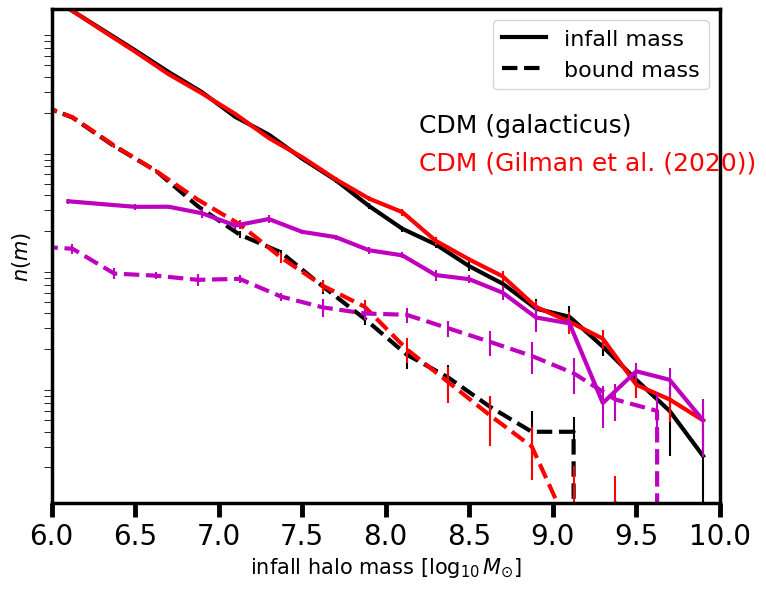

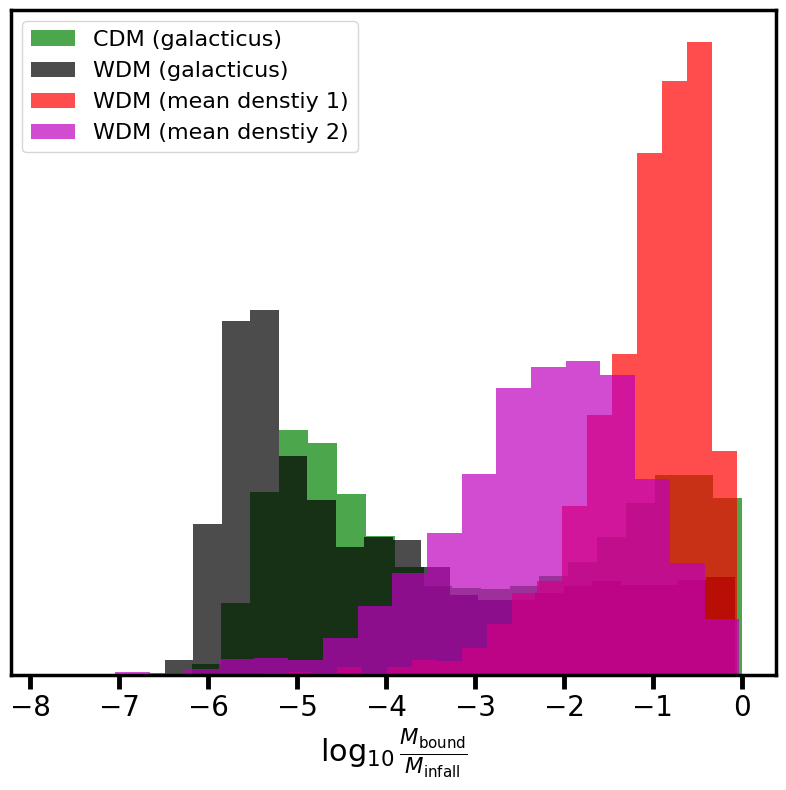

In [4]:
fig = plt.figure(1)
ax = plt.subplot(111)
fig.set_size_inches(8, 6)
kwargs_plot={'lw':3, 'label': 'infall mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'linestyle': '--', 'lw':3, 'label': 'bound mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')


kwargs_plot={'lw':3}
plot_subhalo_mass_functon(cdm_truncation_roche, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(cdm_truncation_roche, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_1, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='m')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_mean_density_2, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='m')

plt.annotate('CDM (galacticus)', fontsize=18, color='k', xy=(0.55, 0.75), xycoords='axes fraction')
plt.annotate('CDM (Gilman et al. (2020))', fontsize=18, color='r', xy=(0.55, 0.675), xycoords='axes fraction')
plt.legend(fontsize=16, frameon=False)
plt.xlim(6.0, 10.0)
plt.ylim(1.0, 15000)
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/bound_mass_functions_rochevsgalacticus.pdf')

plt.gca().set_yticks([])
plt.legend(fontsize=16)
plt.tight_layout()

fig = plt.figure(2)
fig.set_size_inches(8,8)
ax = plt.subplot(111)
mass_range = [6.0, 10.0]
kwargs_plot={'alpha': 0.7, 'label': 'CDM (galacticus)', 'bins': 20}
plot_bound_mass_histogram(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='g', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.7, 'label': 'WDM (galacticus)', 'bins': 20}
plot_bound_mass_histogram(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.7, 'label': 'WDM (mean denstiy 1)', 'bins': 20}
plot_bound_mass_histogram(wdm_truncation_mean_density_1, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='r', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.7, 'label': 'WDM (mean denstiy 2)', 'bins': 20}
plot_bound_mass_histogram(wdm_truncation_mean_density_2, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='m', log_mlow=mass_range[0], log_mhigh=mass_range[1])

plt.gca().set_yticks([])
plt.legend(fontsize=16)
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/bound_mass_histogram_rochevsgalacticus.pdf')

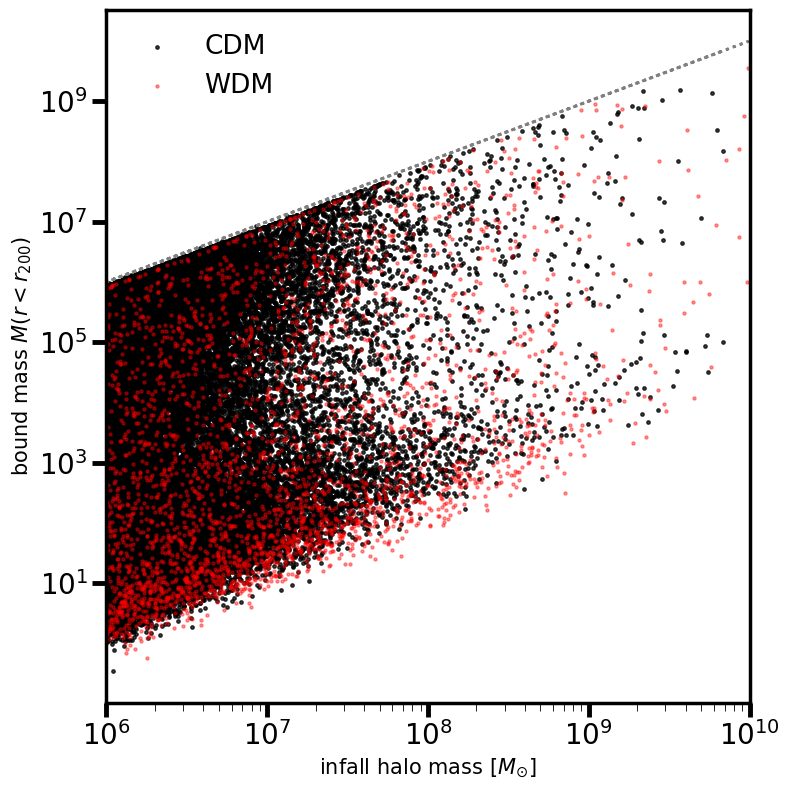

In [5]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
ax = plt.subplot(111)
kwargs_plot={'alpha': 0.75,'s': 6, 'label': 'CDM'}
plot_subhalo_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'alpha': 0.4,'s': 5, 'label': 'WDM'}
plot_subhalo_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='r')
ax.legend(fontsize=19, frameon=False)
ax.set_ylabel('bound mass '+r'$M\left(r<r_{200}\right)$')
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/bound_mass_versus_infall_mass.pdf')

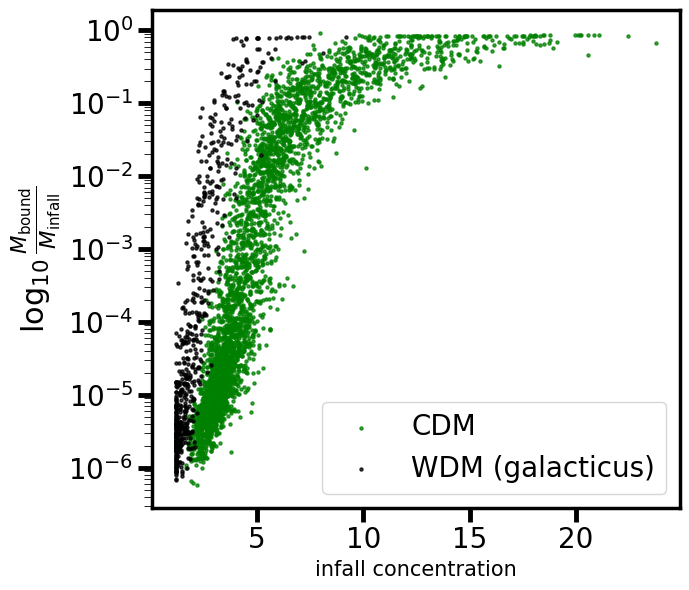

In [6]:
fig = plt.figure(1)
fig.set_size_inches(7,6)
ax = plt.subplot(111)
mass_range = [7.0, 7.5]
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'CDM'}
plot_subhalo_concentration_versus_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='g', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM (galacticus)'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
plt.tight_layout()
plt.legend(fontsize=20)
#plt.savefig('./galacticus_truncation_figures/infallc_versus_boundmass.pdf')
plt.show()



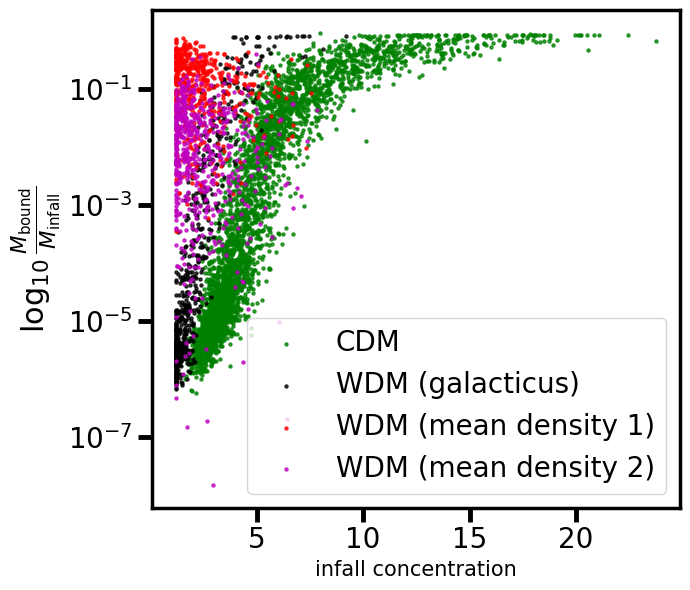

In [7]:
fig = plt.figure(1)
fig.set_size_inches(7,6)
ax = plt.subplot(111)
mass_range = [7.0, 7.5]
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'CDM'}
plot_subhalo_concentration_versus_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='g', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM (galacticus)'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM (mean density 1)'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_mean_density_1, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='r', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM (mean density 2)'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_mean_density_2, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='m', log_mlow=mass_range[0], log_mhigh=mass_range[1])
plt.tight_layout()
plt.legend(fontsize=20)
#plt.savefig('./galacticus_truncation_figures/infallc_versus_boundmass.pdf')
plt.show()



In [8]:
from pyHalo.Halos.galacticus_truncation.interp_mass_loss import InterpGalacticusKeeley24 

interp_galacticus = InterpGalacticusKeeley24()
help(interp_galacticus)

Help on InterpGalacticusKeeley24 in module pyHalo.Halos.galacticus_truncation.interp_mass_loss object:

class InterpGalacticusKeeley24(builtins.object)
 |  This class interpolates output from the semi-analytic model galacticus to predict the bound mass of a subhalo
 |  as a function of its infall mass, concentration, host halo concentration, and the time since infall.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, log10_concentration_infall, time_since_infall, host_concentration)
 |      Evaluates the prediction from galacticus for subhalo bound mass
 |      :param log10_concentration_infall: log10(c) where c is the halo concentration at infall
 |      :param time_since_infall: the time ellapsed since infall and the deflector redshift
 |      :param host_concentration: the concentration of the host halo
 |      :return: the log10(bound mass divided by the infall mass), plus scatter
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |

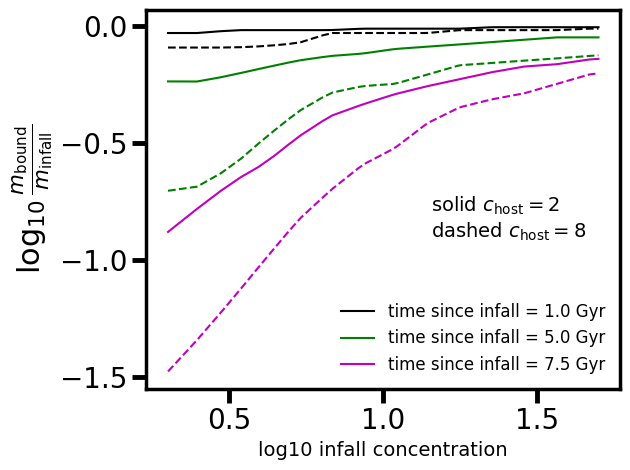

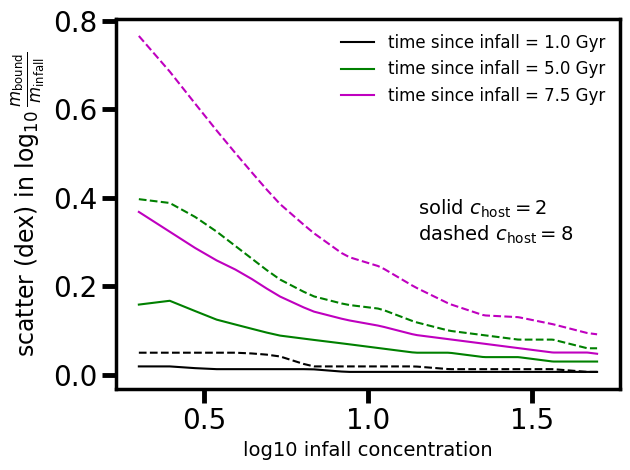

In [9]:

plt.figure(1)
log10c = np.log10(np.linspace(2.0, 50.0, 100))
time_since_infall = 0.25
host_concentration = 2.
ml_mean1 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
time_since_infall = 2.0
ml_mean2 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
time_since_infall = 5.0
ml_mean3 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
plt.plot(log10c, ml_mean1, color='k', label='time since infall = 1.0 Gyr')
plt.plot(log10c, ml_mean2, color='g', label='time since infall = 5.0 Gyr')
plt.plot(log10c, ml_mean3, color='m', label='time since infall = 7.5 Gyr')

time_since_infall = 0.25
host_concentration = 8.0
ml_mean1 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
time_since_infall = 2.0
ml_mean2 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
time_since_infall = 5.0
ml_mean3 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
plt.plot(log10c, ml_mean1, color='k', linestyle='--')
plt.plot(log10c, ml_mean2, color='g', linestyle='--')
plt.plot(log10c, ml_mean3, color='m', linestyle='--')

plt.xlabel('log10 infall concentration', fontsize=14)
plt.ylabel(r'$\log_{10} \frac{m_{\rm{bound}}}{m_{\rm{infall}}}$', fontsize=22)
plt.legend(fontsize=12, frameon=False)
plt.annotate('solid '+r'$c_{\rm{host}}=2$'+'\n'+'dashed '+r'$c_{\rm{host}}=8$', 
             xy=(0.6, 0.4), xycoords='axes fraction', fontsize=14)
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/bound_mass.pdf')

plt.figure(2)
log10c = np.log10(np.linspace(2.0, 50.0, 100))
time_since_infall = 0.25
host_concentration = 2.0
ml_mean1 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)
time_since_infall = 2.0
ml_mean2 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)
time_since_infall = 5.0
ml_mean3 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)

plt.plot(log10c, ml_mean1, color='k', label='time since infall = 1.0 Gyr')
plt.plot(log10c, ml_mean2, color='g', label='time since infall = 5.0 Gyr')
plt.plot(log10c, ml_mean3, color='m', label='time since infall = 7.5 Gyr')

host_concentration = 8.0
time_since_infall = 0.25
ml_mean1 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)
time_since_infall = 2.0
ml_mean2 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)
time_since_infall = 5.0
ml_mean3 = interp_galacticus.evaluate_scatter_dex(log10c, time_since_infall, host_concentration)
plt.plot(log10c, ml_mean1, color='k', linestyle='--')
plt.plot(log10c, ml_mean2, color='g', linestyle='--')
plt.plot(log10c, ml_mean3, color='m', linestyle='--')
plt.annotate('solid '+r'$c_{\rm{host}}=2$'+'\n'+'dashed '+r'$c_{\rm{host}}=8$', 
             xy=(0.6, 0.4), xycoords='axes fraction', fontsize=14)
plt.xlabel('log10 infall concentration', fontsize=14)
plt.ylabel('scatter (dex) in 'r'$\log_{10} \frac{m_{\rm{bound}}}{m_{\rm{infall}}}$', fontsize=17)
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()
#plt.savefig('./galacticus_truncation_figures/scatter_bound_mass.pdf')

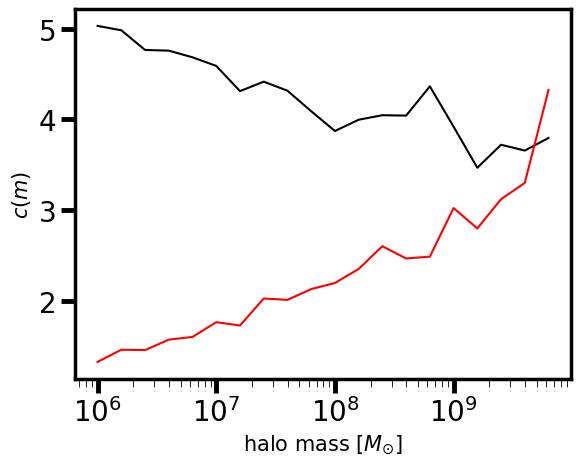

In [10]:
plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(cdm_truncation_galacticus, 0.5, ax=ax)
plot_concentration_mass_relation(wdm_truncation_galacticus, 0.5, ax=ax, color='r')

(-2.0, 0.0)

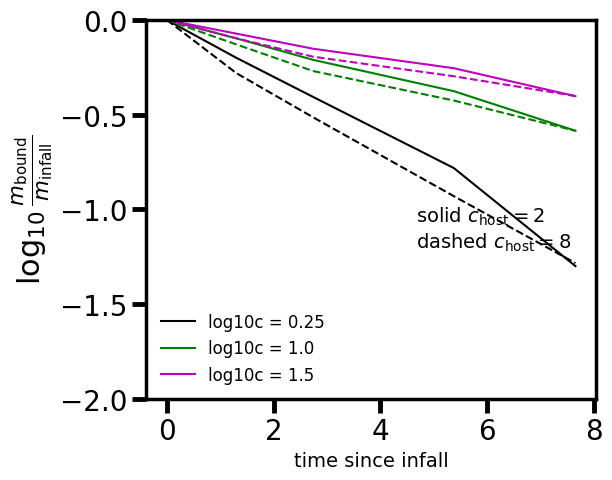

In [11]:
plt.figure(1)
time_since_infall = [0.0, 1.3, 2.741497641811561, 5.377765728095124, 7.658449372663094]
host_concentration = 5.
log10c = np.log10(5.0)
ml_mean1 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
log10c = np.log10(15.0)
ml_mean2 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
log10c = np.log10(30.0)
ml_mean3 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
plt.plot(time_since_infall, ml_mean1, color='k', label='log10c = 0.25')
plt.plot(time_since_infall, ml_mean2, color='g', label='log10c = 1.0')
plt.plot(time_since_infall, ml_mean3, color='m', label='log10c = 1.5')

host_concentration = 8.0
log10c = np.log10(5.0)
ml_mean1 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
log10c = np.log10(15.0)
ml_mean2 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
log10c = np.log10(30.0)
ml_mean3 = interp_galacticus.evaluate_mean_mass_loss(log10c, time_since_infall, host_concentration)
plt.plot(time_since_infall, ml_mean1, color='k', linestyle='--')
plt.plot(time_since_infall, ml_mean2, color='g', linestyle='--')
plt.plot(time_since_infall, ml_mean3, color='m', linestyle='--')

plt.xlabel('time since infall', fontsize=14)
plt.ylabel(r'$\log_{10} \frac{m_{\rm{bound}}}{m_{\rm{infall}}}$', fontsize=22)
plt.legend(fontsize=12, frameon=False)
plt.annotate('solid '+r'$c_{\rm{host}}=2$'+'\n'+'dashed '+r'$c_{\rm{host}}=8$', 
             xy=(0.6, 0.4), xycoords='axes fraction', fontsize=14)
plt.tight_layout()
plt.ylim(-2.0, 0.0)